In [24]:
# tool
import pandas as pd
import matplotlib.pyplot as plt

# data
from neuralforecast.utils import AirPassengersDF

# models
from neuralforecast.auto import AutoNHITS

# forecast
from neuralforecast.core import NeuralForecast

# loss
from neuralforecast.losses.pytorch import MAE

# hyperparameter optim
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)  # disable training prints
from ray import tune
from ray.tune.search.hyperopt import HyperOptSearch

import warnings
warnings.filterwarnings("ignore")

import torch
torch.set_float32_matmul_precision('medium')

# data

In [2]:
Y_df = AirPassengersDF
print(Y_df.head(), "\n")
print(Y_df.tail(), "\n")
print(Y_df.shape, "\n")
print(Y_df["unique_id"].value_counts())

   unique_id         ds      y
0        1.0 1949-01-31  112.0
1        1.0 1949-02-28  118.0
2        1.0 1949-03-31  132.0
3        1.0 1949-04-30  129.0
4        1.0 1949-05-31  121.0 

     unique_id         ds      y
139        1.0 1960-08-31  606.0
140        1.0 1960-09-30  508.0
141        1.0 1960-10-31  461.0
142        1.0 1960-11-30  390.0
143        1.0 1960-12-31  432.0 

(144, 3) 

unique_id
1.0    144
Name: count, dtype: int64


# Ray tune hyperparameter grid

## 默认超参数网格

In [22]:
# Extract the default hyperparameter settings
nhits_config = AutoNHITS.get_default_config(h = 12, backend = "ray")

nhits_config["random_seed"] = tune.randint(1, 10)  # Random seed
nhits_config["n_pool_kernel_size"] = tune.choice([[2, 2, 2], [16, 8, 1]])  # MaxPool's Kernelsize

## 自定义超参数网格

In [32]:
nhits_config = {
    "max_steps": 100,  # Number of SGD steps
    "input_size": 24,  # Size of input window
    "learning_rate": tune.loguniform(1e-5, 1e-1),                              # Initial Learning rate
    "n_pool_kernel_size": tune.choice([[2, 2, 2], [16, 8, 1]]),                # MaxPool's Kernelsize
    "n_freq_downsample": tune.choice([[168, 24, 1], [24, 12, 1], [1, 1, 1]]),  # Interpolation expressivity ratios
    "val_check_steps": 50,  # Compute validation every 50 steps
    "random_seed": tune.randint(1, 10),  # Random seed
}

## model

In [29]:
model = AutoNHITS(
    h = 12,
    loss = MAE(),
    config = nhits_config,
    search_alg = HyperOptSearch(),
    backend = "ray",
    num_samples = 10,
)

## model training

In [30]:
nf = NeuralForecast(models = [model], freq = "M")
nf.fit(df = Y_df, val_size = 24)

(_train_tune pid=28316) D:\software\miniconda3\envs\ts\lib\site-packages\torch\storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
(_train_tune pid=28316)   return t

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 166.68it/s, v_num=0, train_loss_step=18.80, train_loss_epoch=18.70]
Validation: 0it [00:00, ?it/s]
Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 55.51it/s, v_num=0, train_loss_step=18.80, train_loss_epoch=18.70, valid_loss=29.50]
(_train_tune pid=28316) 
Epoch 99:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=13.50, train_loss_epoch=13.50, valid_loss=29.50]         


(_train_tune pid=28316) `Trainer.fit` stopped: `max_steps=100` reached.
2024-12-07 21:58:22,183	INFO tensorboardx.py:311 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'n_freq_downsample': (168, 24, 1), 'n_pool_kernel_size': (16, 8, 1), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 165.93it/s, v_num=0, train_loss_step=13.40, train_loss_epoch=13.50, valid_loss=29.50]
Validation: 0it [00:00, ?it/s]
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 56.76it/s, v_num=0, train_loss_step=13.40, train_loss_epoch=13.40, valid_loss=22.20]


(_train_tune pid=29584) D:\software\miniconda3\envs\ts\lib\site-packages\torch\storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
(_train_tune pid=29584)   return t

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 153.55it/s, v_num=0, train_loss_step=17.70, train_loss_epoch=18.50]
Validation: 0it [00:00, ?it/s]
Epoch 84:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=13.10, train_loss_epoch=13.10, valid_loss=27.00]         


(_train_tune pid=29584) `Trainer.fit` stopped: `max_steps=100` reached.
2024-12-07 21:58:30,409	INFO tensorboardx.py:311 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'n_freq_downsample': (24, 12, 1), 'n_pool_kernel_size': (2, 2, 2), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 221.91it/s, v_num=0, train_loss_step=12.30, train_loss_epoch=12.30, valid_loss=27.00]
(_train_tune pid=29584) 
Validation: 0it [00:00, ?it/s]
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 62.44it/s, v_num=0, train_loss_step=12.30, train_loss_epoch=12.30, valid_loss=20.00]


(_train_tune pid=28456) D:\software\miniconda3\envs\ts\lib\site-packages\torch\storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
(_train_tune pid=28456)   return t

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 166.65it/s, v_num=0, train_loss_step=39.20, train_loss_epoch=38.40]
(_train_tune pid=28456) 
Validation: 0it [00:00, ?it/s]
Epoch 79:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=36.90, train_loss_epoch=36.90, valid_loss=63.70]         


(_train_tune pid=28456) `Trainer.fit` stopped: `max_steps=100` reached.
2024-12-07 21:58:38,444	INFO tensorboardx.py:311 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'n_freq_downsample': (1, 1, 1), 'n_pool_kernel_size': (16, 8, 1), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 200.03it/s, v_num=0, train_loss_step=35.40, train_loss_epoch=35.70, valid_loss=63.70]
Validation: 0it [00:00, ?it/s]
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 60.43it/s, v_num=0, train_loss_step=35.40, train_loss_epoch=35.40, valid_loss=58.80]


(_train_tune pid=27784) D:\software\miniconda3\envs\ts\lib\site-packages\torch\storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
(_train_tune pid=27784)   return t

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 181.59it/s, v_num=0, train_loss_step=18.50, train_loss_epoch=18.50]
Validation: 0it [00:00, ?it/s]
Epoch 94:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=12.90, train_loss_epoch=12.90, valid_loss=28.40]         


(_train_tune pid=27784) `Trainer.fit` stopped: `max_steps=100` reached.
2024-12-07 21:58:46,521	INFO tensorboardx.py:311 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'n_freq_downsample': (24, 12, 1), 'n_pool_kernel_size': (16, 8, 1), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 153.64it/s, v_num=0, train_loss_step=13.20, train_loss_epoch=12.90, valid_loss=28.40]
Validation: 0it [00:00, ?it/s]
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 43.17it/s, v_num=0, train_loss_step=13.20, train_loss_epoch=13.20, valid_loss=19.90]


(_train_tune pid=28964) D:\software\miniconda3\envs\ts\lib\site-packages\torch\storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
(_train_tune pid=28964)   return t

Sanity Checking: 0it [00:00, ?it/s]
Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 144.03it/s, v_num=0, train_loss_step=1.32e+11, train_loss_epoch=2.84e+10]
Validation: 0it [00:00, ?it/s]
Epoch 95:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=2.1e+8, train_loss_epoch=2.1e+8, valid_loss=5.48e+10]           


(_train_tune pid=28964) `Trainer.fit` stopped: `max_steps=100` reached.
2024-12-07 21:58:54,400	INFO tensorboardx.py:311 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'n_freq_downsample': (1, 1, 1), 'n_pool_kernel_size': (16, 8, 1), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 177.30it/s, v_num=0, train_loss_step=8.52e+7, train_loss_epoch=1.08e+8, valid_loss=5.48e+10]
(_train_tune pid=28964) 
Validation: 0it [00:00, ?it/s]
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 47.28it/s, v_num=0, train_loss_step=8.52e+7, train_loss_epoch=8.52e+7, valid_loss=1.39e+8]


(_train_tune pid=29684) D:\software\miniconda3\envs\ts\lib\site-packages\torch\storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
(_train_tune pid=29684)   return t

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 141.87it/s, v_num=0, train_loss_step=1.5e+10, train_loss_epoch=2.16e+10] 
Validation: 0it [00:00, ?it/s]
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 166.63it/s, v_num=0, train_loss_step=5.24e+8, train_loss_epoch=7.44e+8, valid_loss=1.13e+10]
Validation: 0it [00:00, ?it/s]
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 57.10it/s, v_num=0, train_loss_step=5.24e+8, train_loss_epoch=5.24e+8, valid_loss=8.05e+8]


(_train_tune pid=29684) `Trainer.fit` stopped: `max_steps=100` reached.
2024-12-07 21:59:02,413	INFO tensorboardx.py:311 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'n_freq_downsample': (168, 24, 1), 'n_pool_kernel_size': (2, 2, 2), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=28500) D:\software\miniconda3\envs\ts\lib\site-packages\torch\storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this 

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 181.59it/s, v_num=0, train_loss_step=14.30, train_loss_epoch=14.50]
(_train_tune pid=28500) 
Validation: 0it [00:00, ?it/s]
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 154.36it/s, v_num=0, train_loss_step=10.80, train_loss_epoch=10.50, valid_loss=24.70]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 398.66it/s]


(_train_tune pid=28500) `Trainer.fit` stopped: `max_steps=100` reached.
2024-12-07 21:59:10,507	INFO tensorboardx.py:311 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'n_freq_downsample': (168, 24, 1), 'n_pool_kernel_size': (2, 2, 2), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 46.52it/s, v_num=0, train_loss_step=10.80, train_loss_epoch=10.80, valid_loss=18.70]


(_train_tune pid=16948) D:\software\miniconda3\envs\ts\lib\site-packages\torch\storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
(_train_tune pid=16948)   return t

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 153.69it/s, v_num=0, train_loss_step=11.00, train_loss_epoch=11.30]
Validation: 0it [00:00, ?it/s]
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 181.69it/s, v_num=0, train_loss_step=7.740, train_loss_epoch=7.600, valid_loss=16.60]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 500.04it/s]


(_train_tune pid=16948) `Trainer.fit` stopped: `max_steps=100` reached.
2024-12-07 21:59:18,455	INFO tensorboardx.py:311 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'n_freq_downsample': (168, 24, 1), 'n_pool_kernel_size': (16, 8, 1), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 58.74it/s, v_num=0, train_loss_step=7.740, train_loss_epoch=7.740, valid_loss=17.40]


(_train_tune pid=29184) D:\software\miniconda3\envs\ts\lib\site-packages\torch\storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
(_train_tune pid=29184)   return t

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 166.56it/s, v_num=0, train_loss_step=3.69e+4, train_loss_epoch=1.65e+7]
Validation: 0it [00:00, ?it/s]
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 153.71it/s, v_num=0, train_loss_step=175.0, train_loss_epoch=1.23e+3, valid_loss=5.54e+7]  
(_train_tune pid=29184) 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 500.27it/s]


(_train_tune pid=29184) `Trainer.fit` stopped: `max_steps=100` reached.
2024-12-07 21:59:26,718	INFO tensorboardx.py:311 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'n_freq_downsample': (168, 24, 1), 'n_pool_kernel_size': (16, 8, 1), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 42.23it/s, v_num=0, train_loss_step=175.0, train_loss_epoch=175.0, valid_loss=901.0]  


(_train_tune pid=19260) D:\software\miniconda3\envs\ts\lib\site-packages\torch\storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
(_train_tune pid=19260)   return t

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 166.55it/s, v_num=0, train_loss_step=22.10, train_loss_epoch=22.70]
Validation: 0it [00:00, ?it/s]
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 181.60it/s, v_num=0, train_loss_step=16.30, train_loss_epoch=16.10, valid_loss=33.20]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 499.74it/s]


(_train_tune pid=19260) `Trainer.fit` stopped: `max_steps=100` reached.
2024-12-07 21:59:34,757	INFO tensorboardx.py:311 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'n_freq_downsample': (1, 1, 1), 'n_pool_kernel_size': (2, 2, 2), 'valid_loss': ('__ref_ph', '004b9a7a')}
2024-12-07 21:59:34,767	WARNING experiment_state.py:205 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this error by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0).
2024-12-07 21:59:34,775	INFO tune.py:1016 -- Wrote the latest version of al

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 56.99it/s, v_num=0, train_loss_step=16.30, train_loss_epoch=16.30, valid_loss=26.20]


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MAE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 2.4 M 
-----------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.698     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.


In [31]:
results = nf.models[0].results.get_dataframe()
results

,loss,train_loss,timestamp,checkpoint_dir_name,done,training_iteration,trial_id,date,time_this_iter_s,time_total_s,...,config/input_size,config/learning_rate,config/n_pool_kernel_size,config/n_freq_downsample,config/val_check_steps,config/random_seed,config/h,config/loss,config/valid_loss,logdir
0,2.216895e+01,1.340130e+01,1733579902,None,False,2,d3dad1d8,2024-12-07_21-58-22,0.342520,2.897422,...,24,0.000390,"(16, 8, 1)","(168, 24, 1)",50,9,12,MAE(),MAE(),d3dad1d8
1,2.002962e+01,1.226470e+01,1733579910,None,False,2,c1f2e0f1,2024-12-07_21-58-30,0.366552,2.744386,...,24,0.000966,"(2, 2, 2)","(24, 12, 1)",50,2,12,MAE(),MAE(),c1f2e0f1
2,5.880766e+01,3.541467e+01,1733579918,None,False,2,527653e3,2024-12-07_21-58-38,0.382810,2.723147,...,24,0.000024,"(16, 8, 1)","(1, 1, 1)",50,9,12,MAE(),MAE(),527653e3
3,1.992324e+01,1.318050e+01,1733579926,None,False,2,1e067e90,2024-12-07_21-58-46,0.363365,2.716915,...,24,0.000860,"(16, 8, 1)","(24, 12, 1)",50,7,12,MAE(),MAE(),1e067e90
4,1.392712e+08,8.516460e+07,1733579934,None,False,2,9350a408,2024-12-07_21-58-54,0.355987,2.656157,...,24,0.068864,"(16, 8, 1)","(1, 1, 1)",50,7,12,MAE(),MAE(),9350a408
5,8.048640e+08,5.235734e+08,1733579942,None,False,2,6ed39a0e,2024-12-07_21-59-02,0.343608,2.597581,...,24,0.094046,"(2, 2, 2)","(168, 24, 1)",50,3,12,MAE(),MAE(),6ed39a0e
6,1.874331e+01,1.079683e+01,1733579950,None,False,2,391f076b,2024-12-07_21-59-10,0.337792,2.644845,...,24,0.002315,"(2, 2, 2)","(168, 24, 1)",50,3,12,MAE(),MAE(),391f076b
7,1.736157e+01,7.742190e+00,1733579958,None,False,2,6399b58a,2024-12-07_21-59-18,0.342476,2.559814,...,24,0.003473,"(16, 8, 1)","(168, 24, 1)",50,8,12,MAE(),MAE(),6399b58a
8,9.014131e+02,1.747967e+02,1733579966,None,False,2,776d348f,2024-12-07_21-59-26,0.351033,2.613345,...,24,0.063816,"(16, 8, 1)","(168, 24, 1)",50,4,12,MAE(),MAE(),776d348f
9,2.620863e+01,1.634403e+01,1733579974,None,False,2,afc3d5ee,2024-12-07_21-59-34,0.357179,2.611377,...,24,0.000085,"(2, 2, 2)","(1, 1, 1)",50,2,12,MAE(),MAE(),afc3d5ee


## model predicting

In [35]:
Y_hat_df_ray = nf.predict()
Y_hat_df_ray = Y_hat_df_ray.reset_index()
Y_hat_df_ray

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

,unique_id,ds,AutoNHITS
0,1.0,1961-01-31,451.086975
1,1.0,1961-02-28,424.009766
2,1.0,1961-03-31,497.700134
3,1.0,1961-04-30,498.298645
4,1.0,1961-05-31,512.604980
5,1.0,1961-06-30,589.544495
6,1.0,1961-07-31,680.899780
7,1.0,1961-08-31,675.768188
8,1.0,1961-09-30,570.443115
9,1.0,1961-10-31,502.836853


# Optuna hyperparameters grid

## 默认超参数网格

In [7]:
nhits_default_config = AutoNHITS.get_default_config(h = 12, backend = "optuna")
print(nhits_default_config)

def config_nhits(trial):
    config = {
        **nhits_default_config(trial)
    }
    config.update({
        "random_seed": trial.suggest_int("random_seed", 1, 10),
        "n_pool_kernel_size": trial.suggest_categorical("n_pool_kernel_size", [[2, 2, 2], [16, 8, 1]]),
    })

    return config

<function BaseAuto._ray_config_to_optuna.<locals>.optuna_config at 0x000001A0024C19D0>


## 自定超参数网格

In [8]:
def config_nhits(trial):
    return {
        "max_steps": 100,  # Number of SGD steps
        "input_size": 24,  # Size of input window
        "learning_rate": trial.suggest_loguniform(
            "learning_rate", 
            1e-5, 1e-1
        ),  # Initial Learning rate
        "n_pool_kernel_size": trial.suggest_categorical(
            "n_pool_kernel_size", 
            [[2, 2, 2], [16, 8, 1]]
        ),  # MaxPool's Kernelsize
        "n_freq_downsample": trial.suggest_categorical(
            "n_freq_downsample", 
            [[168, 24, 1], [24, 12, 1], [1, 1, 1]]
        ),  # Interpolation expressivity ratios
        "val_check_steps": 50,  # Compute validation every 50 steps
        "random_seed": trial.suggest_int(
            "random_seed",
            1, 10
        ),  # Random seed
    }

## model

In [9]:
model = AutoNHITS(
    h = 12,
    loss = MAE(),
    config = config_nhits,
    search_alg = optuna.samplers.TPESampler(),
    backend = "optuna",
    num_samples = 10,
)

## model training

In [13]:
nf = NeuralForecast(models = [model], freq = "M")
nf.fit(df = Y_df, val_size = 24)

Global seed set to 9
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MAE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 2.4 M 
-----------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.743     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Global seed set to 7
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MAE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 2.4 M 
-----------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.757     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Global seed set to 9
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MAE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 2.4 M 
-----------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.712     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Global seed set to 7
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MAE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 2.4 M 
-----------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.743     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Global seed set to 10
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MAE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 2.4 M 
-----------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.757     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Global seed set to 9
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MAE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 2.4 M 
-----------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.743     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Global seed set to 6
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MAE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 2.4 M 
-----------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.712     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Global seed set to 2
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MAE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 2.4 M 
-----------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.698     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Global seed set to 7
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MAE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 2.4 M 
-----------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.712     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Global seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MAE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 2.4 M 
-----------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.757     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Global seed set to 9
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MAE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 2.4 M 
-----------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.712     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.


In [17]:
results = nf.models[0].results.trials_dataframe()
results.drop(columns = "user_attrs_ALL_PARAMS")

,number,value,datetime_start,datetime_complete,duration,params_learning_rate,params_n_freq_downsample,params_n_pool_kernel_size,params_random_seed,user_attrs_METRICS,state
0,0,1.688148e+01,2024-12-07 21:07:10.355972,2024-12-07 21:07:11.927400,0 days 00:00:01.571428,0.002851,"[1, 1, 1]","[16, 8, 1]",9,"{'loss': tensor(16.8815), 'train_loss': tensor...",COMPLETE
1,1,1.645361e+01,2024-12-07 21:07:11.928402,2024-12-07 21:07:13.321231,0 days 00:00:01.392829,0.004284,"[1, 1, 1]","[2, 2, 2]",7,"{'loss': tensor(16.4536), 'train_loss': tensor...",COMPLETE
2,2,1.547846e+01,2024-12-07 21:07:13.321231,2024-12-07 21:07:14.602140,0 days 00:00:01.280909,0.004060,"[24, 12, 1]","[2, 2, 2]",9,"{'loss': tensor(15.4785), 'train_loss': tensor...",COMPLETE
3,3,1.273332e+08,2024-12-07 21:07:14.603141,2024-12-07 21:07:15.905151,0 days 00:00:01.302010,0.069764,"[1, 1, 1]","[16, 8, 1]",7,"{'loss': tensor(1.2733e+08), 'train_loss': ten...",COMPLETE
4,4,2.245753e+01,2024-12-07 21:07:15.905151,2024-12-07 21:07:17.269298,0 days 00:00:01.364147,0.000101,"[1, 1, 1]","[2, 2, 2]",10,"{'loss': tensor(22.4575), 'train_loss': tensor...",COMPLETE
5,5,6.207273e+01,2024-12-07 21:07:17.269298,2024-12-07 21:07:18.598028,0 days 00:00:01.328730,0.000018,"[1, 1, 1]","[16, 8, 1]",9,"{'loss': tensor(62.0727), 'train_loss': tensor...",COMPLETE
6,6,3.401863e+01,2024-12-07 21:07:18.598028,2024-12-07 21:07:19.964827,0 days 00:00:01.366799,0.000060,"[168, 24, 1]","[2, 2, 2]",6,"{'loss': tensor(34.0186), 'train_loss': tensor...",COMPLETE
7,7,1.661212e+01,2024-12-07 21:07:19.964827,2024-12-07 21:07:21.420339,0 days 00:00:01.455512,0.005575,"[24, 12, 1]","[16, 8, 1]",2,"{'loss': tensor(16.6121), 'train_loss': tensor...",COMPLETE
8,8,5.422427e+01,2024-12-07 21:07:21.420339,2024-12-07 21:07:22.651821,0 days 00:00:01.231482,0.000017,"[168, 24, 1]","[2, 2, 2]",7,"{'loss': tensor(54.2243), 'train_loss': tensor...",COMPLETE
9,9,1.772611e+01,2024-12-07 21:07:22.651821,2024-12-07 21:07:23.968419,0 days 00:00:01.316598,0.001261,"[1, 1, 1]","[2, 2, 2]",1,"{'loss': tensor(17.7261), 'train_loss': tensor...",COMPLETE


## model predicting

In [18]:
Y_hat_df_optuna = nf.predict()
Y_hat_df_optuna = Y_hat_df_optuna.reset_index()
Y_hat_df_optuna

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

,unique_id,ds,AutoNHITS
0,1.0,1961-01-31,453.378510
1,1.0,1961-02-28,425.522949
2,1.0,1961-03-31,495.473328
3,1.0,1961-04-30,503.095551
4,1.0,1961-05-31,510.216248
5,1.0,1961-06-30,576.599426
6,1.0,1961-07-31,666.714111
7,1.0,1961-08-31,674.762451
8,1.0,1961-09-30,585.423401
9,1.0,1961-10-31,506.677429


# result

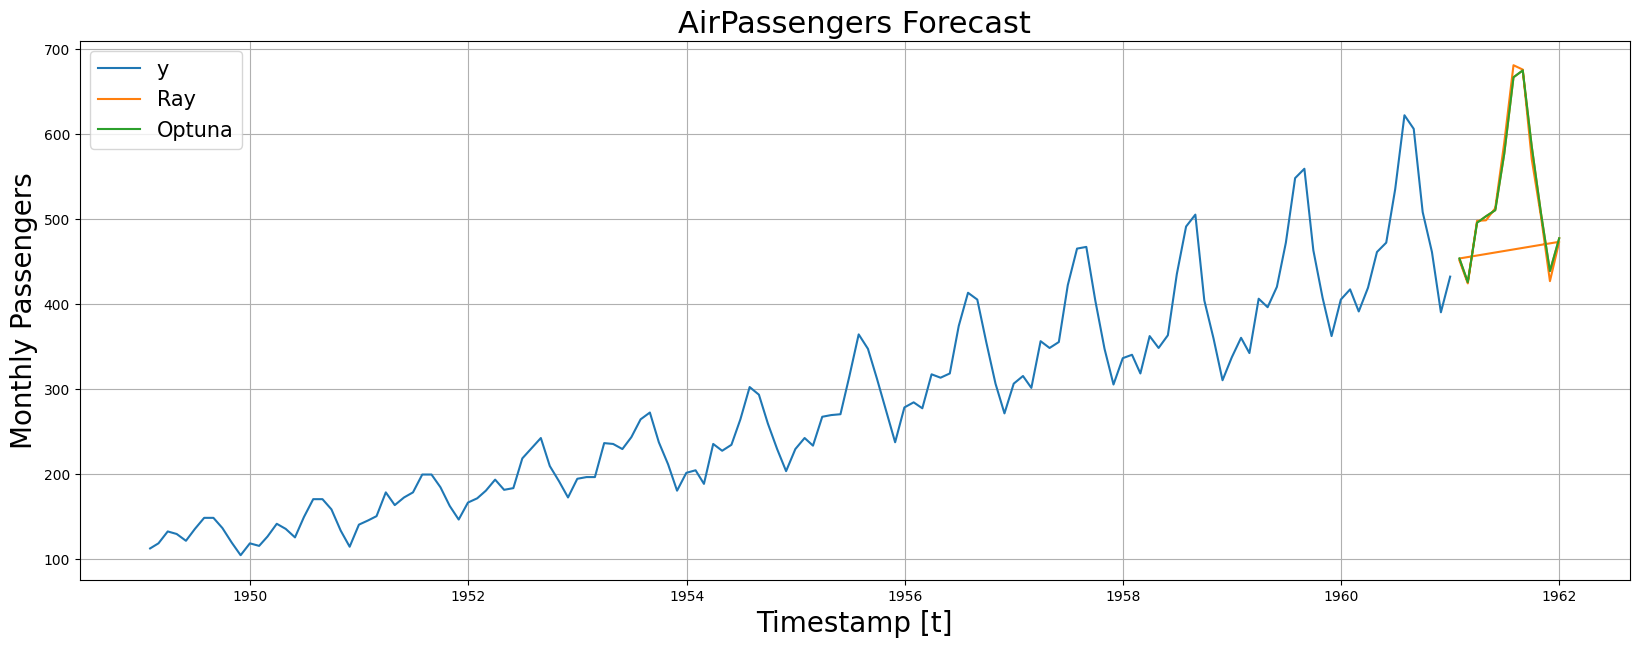

In [36]:
plot_df = pd.concat([
    Y_df,
    Y_hat_df_ray,
    Y_hat_df_optuna,
]).reset_index()

fig, ax = plt.subplots(1, 1, figsize = (20, 7))
plt.plot(plot_df['ds'], plot_df['y'], label='y')
plt.plot(plot_df['ds'], plot_df['AutoNHITS'], label='Ray')
plt.plot(Y_hat_df_optuna['ds'], Y_hat_df_optuna['AutoNHITS'], label='Optuna')
ax.set_title('AirPassengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()